In [1]:
import numpy as np,pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold,KFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

pd.set_option('max_columns',200)
pd.set_option('max_rows',200)
pd.set_option('max_colwidth',200)

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [2]:
dtypes = {"session_id": 'int64',
          "index": np.int16,
          "elapsed_time": np.int32,
          "event_name": 'category',
          "name": 'category',
          "level": np.int8,
          "page": np.float16,
          "room_coor_x": np.float16,
          "room_coor_y": np.float16,
          "screen_coor_x": np.float16,
          "screen_coor_y": np.float16,
          "hover_duration": np.float32,
          "text": 'category',
          "fqid": 'category',
          "room_fqid": 'category',
          "text_fqid": 'category',
          "fullscreen": np.int8,
          "hq": np.int8,
          "music": np.int8,
          "level_group": 'category'
          }

In [3]:
%%time
df_train = pd.read_csv('../dataset/train.csv',dtype=dtypes,nrows=20)
df_train.head()

Wall time: 20 ms


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4


In [5]:
df_train['index'].map(lambda x:x*x)

0       0
1       1
2       4
3       9
4      16
5      25
6      36
7      49
8      64
9      81
10    100
11    121
12    144
13    169
14    196
15    225
16    256
17    289
18    324
19    361
Name: index, dtype: int64

In [13]:
table = pd.pivot_table(df_train,values='index',index=['session_id','level_group'],columns='event_name',aggfunc='count')
table

,event_name,cutscene_click,navigate_click,observation_click,person_click
session_id,level_group,,,,
20090312431273200,0-4,1,8,1,10


In [23]:
df_train.groupby

TypeError: cannot insert an item into a CategoricalIndex that is not already an existing category

In [4]:
col_astypes = ['room_coor_x','room_coor_y','screen_coor_x','screen_coor_y']
for col in col_astypes:
    df_train[col] = df_train[col].astype('float64')

In [5]:
%%time
labels = pd.read_csv('../dataset/train_labels.csv')
labels['session'] = labels['session_id'].apply(lambda x:int(x.split('_')[0]))
labels['q'] = labels['session_id'].apply(lambda x:int(x.split('q')[1]))
labels.head()

Wall time: 697 ms


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


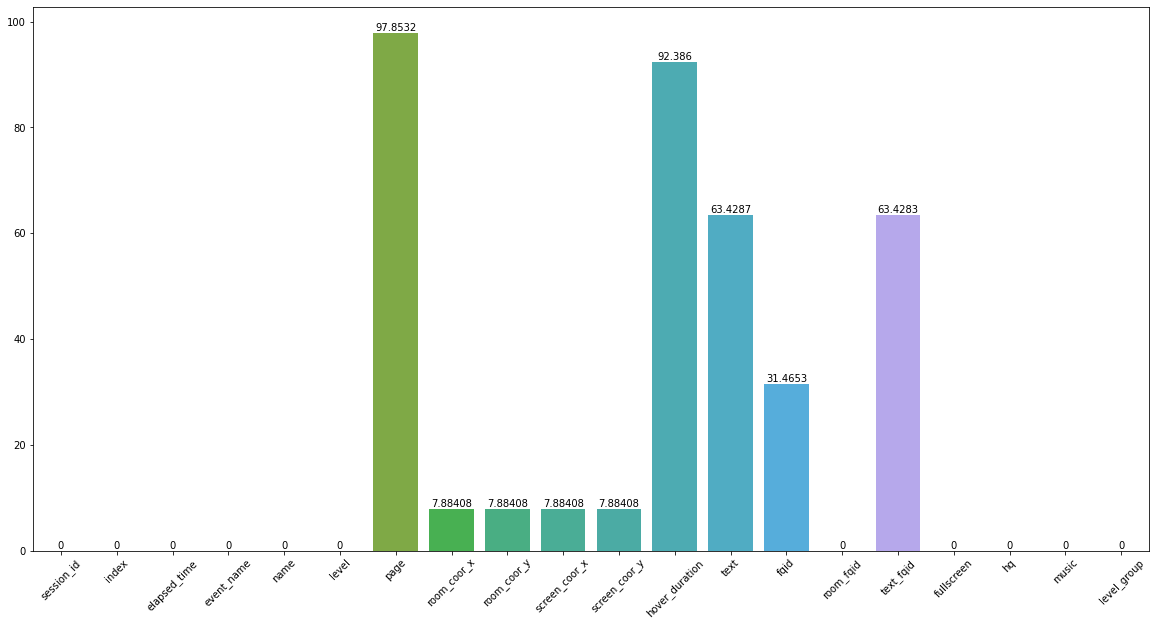

In [22]:
import seaborn as sns
missing_data = df_train.isnull().sum()/len(df_train) * 100
plt.figure(figsize=(20,10))
g = sns.barplot(x = missing_data.index,y = missing_data.values)
g.xaxis.set_tick_params(rotation=45)
g.bar_label(g.containers[0])
plt.show()
del missing_data,g

In [ ]:
ROOM_FQIDS = ['tunic.historicalsociety.closet', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.entry', 
              'tunic.historicalsociety.collection', 'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
              'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty', 'tunic.historicalsociety.frontdesk', 
              'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk', 'tunic.library.frontdesk', 
              'tunic.library.microfiche', 'tunic.capitol_1.hall', 'tunic.historicalsociety.cage', 
              'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center', 'tunic.flaghouse.entry', 
              'tunic.capitol_2.hall']

In [23]:
def featureEng(data):
    NUMS = ['elapsed_time','level','hover_duration','elapsed_time_diff','room_coor_x','room_coor_y','room_coor',
            'screen_coor_x','screen_coor_y','screen_coor','screen_room','room_coor_diff','screen_coor_diff']
    CATS = ['event_name','name','fqid','room_fqid','text']
    EVENTS = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
              'map_click','observation_click','checkpoint']
    NAMES = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
    ROOM_FQIDS = ['tunic.historicalsociety.closet', 'tunic.historicalsociety.basement', 'tunic.historicalsociety.entry', 
              'tunic.historicalsociety.collection', 'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
              'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty', 'tunic.historicalsociety.frontdesk', 
              'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk', 'tunic.library.frontdesk', 
              'tunic.library.microfiche', 'tunic.capitol_1.hall', 'tunic.historicalsociety.cage', 
              'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center', 'tunic.flaghouse.entry', 
              'tunic.capitol_2.hall']
    data['room_coor'] = np.sqrt(np.power(data['room_coor_x'],2) + np.power(data['room_coor_y'],2))
    data['screen_coor'] = np.sqrt(np.power(data['screen_coor_x'],2) + np.power(data['screen_coor_y'],2))
    data['screen_room'] = np.sqrt(np.power(data['room_coor_x']-data['screen_coor_x'],2) + np.power(data['room_coor_y'] - data['screen_coor_y'],2))
    users = data['session_id'].unique().tolist()
    groups = data['level_group'].unique().tolist()
    user_data = []
    name_list = ['session_id','level_group']
    for u in tqdm(users):
        datatemp = data[data['session_id']==u].sort_values(by='index')
        datatemp['elapsed_time_diff'] = datatemp['elapsed_time'].diff().values
        datatemp['room_coor_diff'] = datatemp['room_coor'].diff().values
        datatemp['screen_coor_diff'] = datatemp['screen_coor'].diff().values
        for g in groups:
            data_list = []
            temp = datatemp[datatemp['level_group']==g]
            data_list.append(u)
            data_list.append(g)
            for n in NUMS:
                data_list.append(temp[n].mean())
                data_list.append(temp[n].max() - temp[n].min())
            for n in EVENTS:
                data_list.append(temp[temp['event_name']==n]['elapsed_time'].mean())                
                data_list.append(temp[temp['event_name']==n]['elapsed_time'].max() - temp[temp['event_name']==n]['elapsed_time'].min())
            for n in NAMES:
                data_list.append(temp[temp['name']==n]['elapsed_time'].mean())                
                data_list.append(temp[temp['name']==n]['elapsed_time'].max() - temp[temp['name']==n]['elapsed_time'].min())
            for n in ROOM_FQIDS:
                data_list.append(temp[temp['room_fqid']==n]['elapsed_time'].mean())                
                data_list.append(temp[temp['room_fqid']==n]['elapsed_time'].max() - temp[temp['room_fqid']==n]['elapsed_time'].min())
            
            for e in EVENTS:
                temp[e] = (temp['event_name']==e).astype('int8')
            for e in EVENTS:
                try:
                    data_list.append(temp[e].sum())
                except:
                    data_list.append(0)
            for n in NAMES:
                temp[n] = (temp['name']==n).astype('int8')
            for n in NAMES:
                try:
                    data_list.append(temp[n].sum())
                except:
                    data_list.append(0)
            for r in ROOM_FQIDS:
                temp[r] = (temp['room_fqid']==r).astype('int8')
            for r in ROOM_FQIDS:
                try:
                    data_list.append(temp[r].sum())
                except:
                    data_list.append(0)
            user_data.append(data_list)
    for n in NUMS:
        name1 = n + '_mean'
        name2 = n + '_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for n in EVENTS:
        name1 = n + '_elapsed_time_mean'
        name2 = n + '_elapsed_time_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for n in NAMES:
        name1 = n + '_elapsed_time_mean'
        name2 = n + '_elapsed_time_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for n in ROOM_FQIDS:
        name1 = n + '_elapsed_time_mean'
        name2 = n + '_elapsed_time_sdiff'
        name_list.append(name1)
        name_list.append(name2)
    for e in EVENTS:
        name = e + '_sum'
        name_list.append(name)
    for n in NAMES:
        name = n + '_sum'
        name_list.append(name)
    for r in ROOM_FQIDS:
        name = r + '_counts'
        name_list.append(name)
    dfs = pd.DataFrame(user_data,columns=name_list)
    dfs = dfs.set_index('session_id')
    return dfs

In [24]:
%%time
train = featureEng(df_train)
train.head()


Wall time: 2h 35min 16s


,level_group,elapsed_time_mean,elapsed_time_sdiff,level_mean,level_sdiff,hover_duration_mean,hover_duration_sdiff,elapsed_time_diff_mean,elapsed_time_diff_sdiff,room_coor_x_mean,room_coor_x_sdiff,room_coor_y_mean,room_coor_y_sdiff,room_coor_mean,room_coor_sdiff,screen_coor_x_mean,screen_coor_x_sdiff,screen_coor_y_mean,screen_coor_y_sdiff,screen_coor_mean,screen_coor_sdiff,screen_room_mean,screen_room_sdiff,room_coor_diff_mean,room_coor_diff_sdiff,screen_coor_diff_mean,screen_coor_diff_sdiff,navigate_click_elapsed_time_mean,navigate_click_elapsed_time_sdiff,person_click_elapsed_time_mean,person_click_elapsed_time_sdiff,cutscene_click_elapsed_time_mean,cutscene_click_elapsed_time_sdiff,object_click_elapsed_time_mean,object_click_elapsed_time_sdiff,map_hover_elapsed_time_mean,map_hover_elapsed_time_sdiff,notification_click_elapsed_time_mean,notification_click_elapsed_time_sdiff,map_click_elapsed_time_mean,map_click_elapsed_time_sdiff,observation_click_elapsed_time_mean,observation_click_elapsed_time_sdiff,checkpoint_elapsed_time_mean,checkpoint_elapsed_time_sdiff,basic_elapsed_time_mean,basic_elapsed_time_sdiff,undefined_elapsed_time_mean,undefined_elapsed_time_sdiff,close_elapsed_time_mean,close_elapsed_time_sdiff,open_elapsed_time_mean,open_elapsed_time_sdiff,prev_elapsed_time_mean,prev_elapsed_time_sdiff,next_elapsed_time_mean,next_elapsed_time_sdiff,tunic.historicalsociety.closet_elapsed_time_mean,tunic.historicalsociety.closet_elapsed_time_sdiff,tunic.historicalsociety.basement_elapsed_time_mean,tunic.historicalsociety.basement_elapsed_time_sdiff,tunic.historicalsociety.entry_elapsed_time_mean,tunic.historicalsociety.entry_elapsed_time_sdiff,tunic.historicalsociety.collection_elapsed_time_mean,tunic.historicalsociety.collection_elapsed_time_sdiff,tunic.historicalsociety.stacks_elapsed_time_mean,tunic.historicalsociety.stacks_elapsed_time_sdiff,tunic.kohlcenter.halloffame_elapsed_time_mean,tunic.kohlcenter.halloffame_elapsed_time_sdiff,tunic.capitol_0.hall_elapsed_time_mean,tunic.capitol_0.hall_elapsed_time_sdiff,tunic.historicalsociety.closet_dirty_elapsed_time_mean,tunic.historicalsociety.closet_dirty_elapsed_time_sdiff,tunic.historicalsociety.frontdesk_elapsed_time_mean,tunic.historicalsociety.frontdesk_elapsed_time_sdiff,tunic.humanecology.frontdesk_elapsed_time_mean,tunic.humanecology.frontdesk_elapsed_time_sdiff,tunic.drycleaner.frontdesk_elapsed_time_mean,tunic.drycleaner.frontdesk_elapsed_time_sdiff,tunic.library.frontdesk_elapsed_time_mean,tunic.library.frontdesk_elapsed_time_sdiff,tunic.library.microfiche_elapsed_time_mean,tunic.library.microfiche_elapsed_time_sdiff,tunic.capitol_1.hall_elapsed_time_mean,tunic.capitol_1.hall_elapsed_time_sdiff,tunic.historicalsociety.cage_elapsed_time_mean,tunic.historicalsociety.cage_elapsed_time_sdiff,tunic.historicalsociety.collection_flag_elapsed_time_mean,tunic.historicalsociety.collection_flag_elapsed_time_sdiff,tunic.wildlife.center_elapsed_time_mean,tunic.wildlife.center_elapsed_time_sdiff,tunic.flaghouse.entry_elapsed_time_mean,tunic.flaghouse.entry_elapsed_time_sdiff,tunic.capitol_2.hall_elapsed_time_mean,tunic.capitol_2.hall_elapsed_time_sdiff,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,basic_sum,undefined_sum,close_sum,open_sum,prev_sum,next_sum,tunic.historicalsociety.closet_counts,tunic.historicalsociety.basement_counts,tunic.historicalsociety.entry_counts,tunic.historicalsociety.collection_counts,tunic.historicalsociety.stacks_counts,tunic.kohlcenter.halloffame_counts,tunic.capitol_0.hall_counts,tunic.historicalsociety.closet_dirty_counts,tunic.historicalsociety.frontdesk_counts,tunic.humanecology.frontdesk_counts,tunic.drycleaner.frontdesk_counts,tunic.library.frontdesk_counts,tunic.library.microfiche_counts,tunic.capitol_1.hall_counts,tunic.historicalsociety.cage_counts,tunic.historicalsociety.collection_flag_counts,tunic.wildlife.center_counts,tunic.f

In [25]:
import gc
del df_train;gc.collect()
print(train.shape)
features = [c for c in train.columns if c not in ['level_group']]
all_users = train.index.unique()

(70686, 129)


In [26]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(all_users),18)), index=all_users)
models = {}

for i,(train_index,test_index) in enumerate(gkf.split(X=train, groups=train.index)):
    print('='*80,i,'='*80)
    xgb_params = {
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate':0.005,
        'max_depth':4,
        'n_estimators':2023,
        'early_stopping_rounds':50,
        'tree_method':'gpu_hist',
        'subsample':0.8,
        'colsample_bytree':0.4,
        'use_label_encoder':False
    }
    for t in range(1,19):
        if t<4: grp='0-4'
        elif t<14: grp = '5-12'
        elif t<22: grp='13-22'
            
        train_x = train.iloc[train_index]
        xtrain = train_x.loc[train_x['level_group']==grp]
        train_users = xtrain.index.values
        ytrain = labels.loc[labels.q==t].set_index('session').loc[train_users]
        
        test_x = train.iloc[test_index]
        xtest = test_x.loc[test_x.level_group==grp]
        test_users = xtest.index.values
        ytest = labels.loc[labels.q==t].set_index('session').loc[test_users]
        
        clf = XGBClassifier(**xgb_params)
        clf.fit(xtrain[features].astype('float32'),ytrain['correct'],
               eval_set=[(xtest[features].astype('float32'),ytest['correct'])],
               verbose=0)
        print(f'{t}({clf.best_ntree_limit}) ; ',end='')
        
        models[f'{grp}_{t}'] = clf
        oof.loc[test_users,t-1] = clf.predict_proba(xtest[features].astype('float32'))[:,1]
    print()

================================================================================ 0 ================================================================================
[16:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


1(2023) ; [16:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an is

1(2023) ; [17:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


2(2023) ; [17:02:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


3(2023) ; [17:02:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

2(2023) ; [17:07:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


3(2023) ; [17:07:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


4(2023) ; [17:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

3(2023) ; [17:13:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


4(2023) ; [17:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


5(2023) ; [17:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

4(2023) ; [17:19:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


5(2023) ; [17:19:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


6(2023) ; [17:19:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Paramete

In [27]:
tval = oof.copy()
for k in range(18):
    temp = labels.loc[labels.q==k+1].set_index('session').loc[all_users]
    tval[k] = temp.correct.values

In [28]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0
for threshold in np.arange(0.4,0.8,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(tval.values.reshape((-1)),preds,average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score=m
        best_threshold = threshold
for k in range(18):
    m = f1_score(tval[k].values,(oof[k].values>best_threshold).astype('int'),average='macro')
    print(f'Q{k}: F1=',m)

m = f1_score(tval.values.reshape((-1)),(oof.values.reshape((-1))>best_threshold).astype('int'),average='macro')
print('==> Overall F1 =',m)

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, Q0: F1= 0.6573809116855381
Q1: F1= 0.5042616698201327
Q2: F1= 0.5081555939544803
Q3: F1= 0.640885576388907
Q4: F1= 0.5975581296764692
Q5: F1= 0.6177851208836599
Q6: F1= 0.6031857464050521
Q7: F1= 0.547588354095019
Q8: F1= 0.6112814958587927
Q9: F1= 0.5373264075537428
Q10: F1= 0.5953276425065307
Q11: F1= 0.5079166645215659
Q12: F1= 0.45381648397601587
Q13: F1= 0.6209524223963531
Q14: F1= 0.553479799891397
Q15: F1= 0.4885857114846073
Q16: F1= 0.5496884322392626
Q17: F1= 0.4907053935376085
==> Overall F1 = 0.6861300217010335


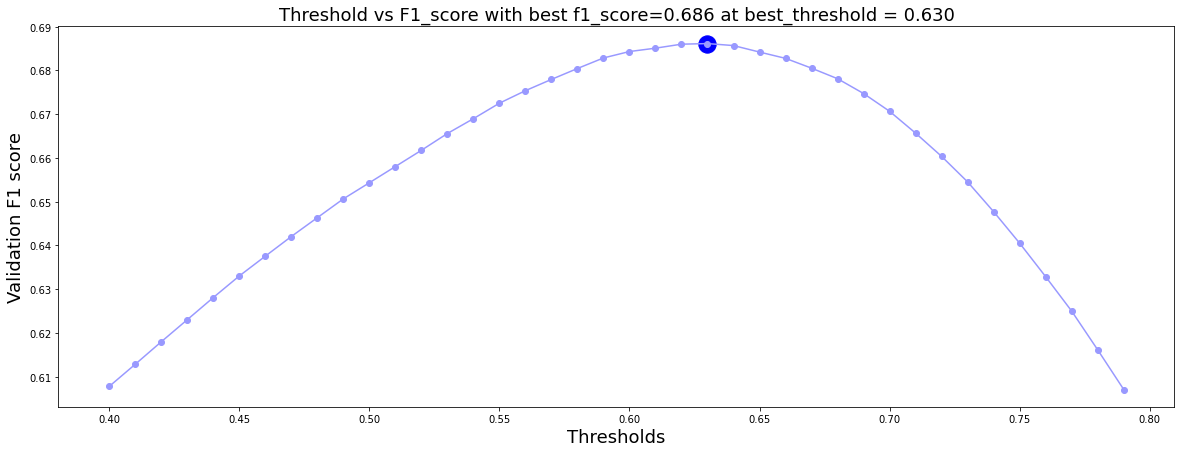

In [29]:
plt.figure(figsize=(20,7))
plt.plot(thresholds,scores,'-o',color='#9999ff')
plt.scatter([best_threshold],[best_score],color='blue',s=300,alpha=1)
plt.xlabel('Thresholds',size=18)
plt.ylabel('Validation F1 score',size=18)
plt.title(f'Threshold vs F1_score with best f1_score={best_score:.3f} at best_threshold = {best_threshold:.3f}',size=18)
plt.show()